In [1]:
#!/usr/bin/env python
"""
Demo for 1D deblurring
--------------------------------------------------------------------------
Created in 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha, Silvia Gazzola, Connor Sanderford, and Ugochukwu Obinna Ugwu"
__affiliations__ = 'Tufts University, University of Bath, Arizona State University, and Tufts University'
__copyright__ = "Copyright 2023, TRIPs-Py library"
__license__ = "GPL"
__version__ = "1.0"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com; sg968@bath.ac.uk; csanderf@asu.edu; connorsanderford@gmail.com; Ugochukwu.Ugwu@tufts.edu"

In [2]:
from trips.test_problems.Deblurring1D import *
from trips.solvers.CGLS import *
#from trips.solvers.arnoldi_tikhonov import *
from trips.solvers.Hybrid_GMRES import *
from trips.solvers.Tikhonov import *
from trips.solvers.GMRES import *
from trips.solvers.golub_kahan_tikhonov import *

In [3]:
import time
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astra
import trips.utilities.phantoms as phantom
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
import scipy.special as spe
from trips.utilities.operators import *
from PIL import Image
from resizeimage import resizeimage
import requests
from os import mkdir
from os.path import exists
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d
from trips.utilities.utils import *
import scipy.linalg as la

In [4]:
D1D = Deblurring1D(CommitCrime = False)

(128, 1)


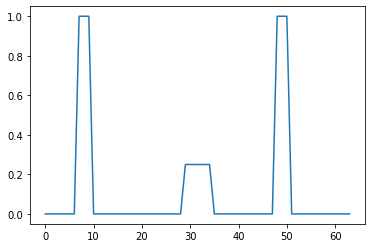

In [5]:
N = 64
x_true = D1D.gen_xtrue(N, test = 'piecewise')
## If you would like to create the operator only
A = D1D.forward_Op_1D(x_true, parameter = 0.4, nx = N) 
## The following creates the data b_true
b_true = D1D.gen_data(x_true)
(b, delta) = D1D.add_noise(b_true, 'Gaussian', 0.05)
plt.plot(x_true)

### Test a methods

##### 1. CGLS

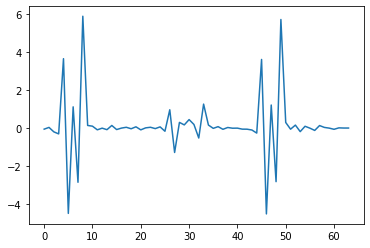

In [6]:
(xcgls, info) = TP_cgls(A, b_true, A.T@b, 20, 1e-3, x_true.reshape((-1,1)))
plt.plot(xcgls.reshape((-1,1)))
rel_residual = info['relResidual']
rel_error = info['relError']

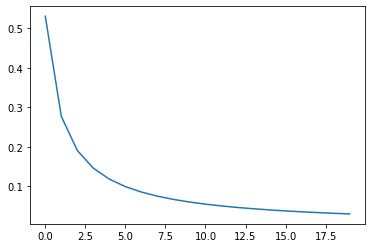

In [7]:

plt.plot(rel_residual)

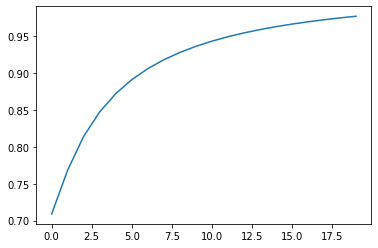

In [8]:
plt.plot(rel_error)

#### The test problem when the operator is not built expliictly

In [9]:
from trips.solvers.Hybrid_GMRES import *

In [10]:
b_vec = b.reshape((-1,1))
(x, info) = Hybrid_GMRES(A, b_vec, n_iter = 9, regparam = 'dp', delta = delta, x_true = x_true, shape = [64, 64])
# outpgcv = hybrid_gmres(A, b_vec, n_iter = 9, regparam = 'gcv', delta = delta, shape = [64, 64])
info['relError']

running Arnoldi algorithm...: 100%|██████████| 9/9 [00:00<00:00, 401.77it/s]


[0.053731852346226086,
 0.06353378055991447,
 0.06367367747269528,
 0.0636734414923017,
 0.06367352479607491,
 0.06367352057706609,
 0.06367352046067022,
 0.06367352113666848,
 0.06367287408892527]

In [11]:
from scipy import linalg as la
b_vec = b.reshape((-1,1))
print(delta)
deltavar = la.norm(b_vec.reshape((-1,1)) - b_true.reshape((-1,1)))
print(deltavar)

0.12624381172952598
0.12624381172952595


running Arnoldi algorithm...: 100%|██████████| 9/9 [00:00<00:00, 763.09it/s]


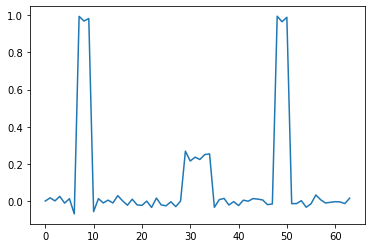

In [34]:
(xarnoldi_tikhonov_dp, info) = Hybrid_GMRES(A, b_vec, n_iter = 9, regparam = 'dp', delta = deltavar, shape = [64, 64])
plt.plot(xarnoldi_tikhonov_dp)

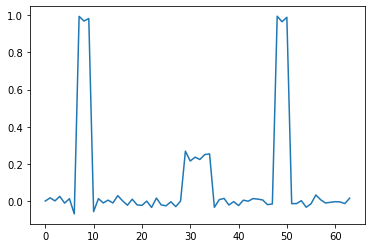

In [35]:
# plt.plot(xarnoldi_tikhonov)
plt.plot(xarnoldi_tikhonov_dp)
# plt.plot(xarnoldi_tikhonov_dpvar)

In [61]:
xarnoldi_tikhonov_dpvar = hybrid_gmres(A, b_vec, n_iter = 9, regparam = 'dp', dp_stop = True, delta = deltavar, shape = [64, 64])[0]
outpdpvar = hybrid_gmres(A, b_vec, n_iter = 9, regparam = 'dp', dp_stop = True, delta = deltavar, shape = [64, 64])
regpdpvar = outpdpvar[3]
print(regpdpvar)

NameError: name 'hybrid_gmres' is not defined

#### The test problem when the operator is built expliictly

In [36]:
# The operator A is built as a matrix
## Note: The parameters defining the operators are different, hence different reconstructions
Amat = D1D.forward_Op_matrix_1D(3, N)

AttributeError: 'Deblurring1Dtest' object has no attribute 'forward_Op_matrix_1D'

AttributeError: 'Deblurring1Dtest' object has no attribute 'plot_data'

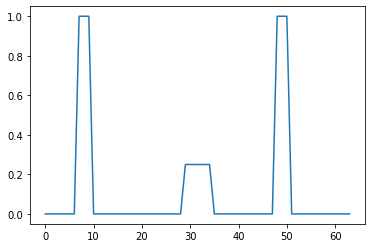

In [38]:
b_true = Amat@x_true
plt.plot(x_true)
D1D.plot_data(b_true)

### Test methods

##### 1. CGLS

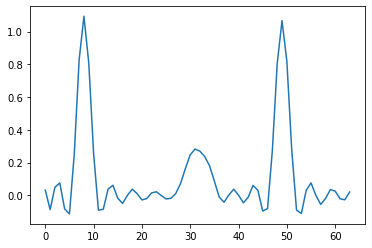

In [14]:
(xcgls, info) = TP_cgls(Amat, b_true, np.zeros((N,1)), 200, 1e-8, x_true)
plt.plot(xcgls.reshape(-1,1))

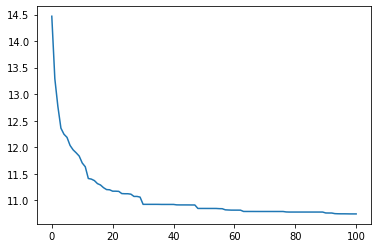

In [15]:
rel_err = info['relError']
plt.plot(rel_err)

#### 2. Arnoldi Tikhonov

In [ ]:
(b, delta) = D1D.add_noise(b_true, 'Gaussian', 0.05) # to be redefined again with the b_true corresponding to Amat

In [ ]:
from scipy import linalg as la
print(delta)
# print(la.norm(b.reshape((-1,1)) - b_true.reshape((-1,1))))
deltavar = la.norm(b.reshape((-1,1)) - b_true.reshape((-1,1)))

In [18]:
b_vec = b.reshape((-1,1))
(xarnoldi_tikhonov, reg_param) = hybrid_gmres(Amat, b_vec, n_iter = 20, regparam = 'dp', delta = deltavar)
plt.plot(xarnoldi_tikhonov)

NameError: name 'Amat' is not defined

In [ ]:
print(la.norm(Amat@xarnoldi_tikhonov - b_vec.reshape((-1,1))))
print(reg_param)

### 3. Golub-Kahan Tikhonov

In [ ]:
b_vec = b.reshape((-1,1))
(xgolub_kahan_tikhonov, reg_param) = golub_kahan_tikhonov(Amat, b_vec, n_iter = 10, regparam = 'gcv', delta = delta)
plt.plot(xgolub_kahan_tikhonov)

#### 4. GMRES


In [ ]:
xgmres = GMRES(A, b, n_iter = 2, dp_stop = 0)

In [ ]:
plt.plot(xgmres)

In [ ]:
## Define the regularization operator as a matrix here

In [ ]:
from trips.utilities.operators import *

In [ ]:
def generate_first_derivative_operator_matrix(n):

    D = sparse.spdiags( data=np.ones(n-1) , diags=-1, m=n, n=n)
    L = sparse.identity(n)-D
    L = L[0:-1, :]

    return L

In [ ]:
L = generate_first_derivative_operator_matrix(4)
L.todense()

In [ ]:
LL = generate_first_derivative_operator_2d_matrix(3,3)